# Steps

County Health Data Processing
- data dictionary files
    - filter columns - only keep raw data
    - select columns
    - check for all year
    - confirm selection
- csv files
    - merge into one dataframe
    - calculation

[CountyHealthRankings](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation)

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [4]:
data_dir = "..\\data\\"

# Data Dictionary

## Extract All Measures

In [5]:
all_measures = {}
not_selected_dict = {}
shapes_dict = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".xlsx") and 'CHR_DD' in filename:
        year = filename[:4]
        df = pd.read_excel(os.path.join(data_dir, filename))

        original_shape = df.shape
        
        mask = df['Variable Name'].str.contains("_numerator|_denominator|_cilow|_cihigh", case=False)
        filtered_df = df[~mask]
        not_selected_dict[year] = df[mask]['Variable Name'].tolist()

        shapes_dict[year] = {"before": original_shape, "after": filtered_df.shape}

        all_measures[year] = [
            (row['Variable Name'], row['Measure'], row.get('Description', None))  # for year 2020, 2021, 2022 only
            for _, row in filtered_df.iterrows() # _ indicates the index
        ]

C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpy

In [6]:
not_selected_dict

{'2011': ['v001_numerator',
  'v001_denominator',
  'v001_cilow',
  'v001_cihigh',
  'v002_numerator',
  'v002_denominator',
  'v002_cilow',
  'v002_cihigh',
  'v036_numerator',
  'v036_denominator',
  'v036_cilow',
  'v036_cihigh',
  'v042_numerator',
  'v042_denominator',
  'v042_cilow',
  'v042_cihigh',
  'v037_numerator',
  'v037_denominator',
  'v037_cilow',
  'v037_cihigh',
  'v009_numerator',
  'v009_denominator',
  'v009_cilow',
  'v009_cihigh',
  'v011_numerator',
  'v011_denominator',
  'v011_cilow',
  'v011_cihigh',
  'v049_numerator',
  'v049_denominator',
  'v049_cilow',
  'v049_cihigh',
  'v039_numerator',
  'v039_denominator',
  'v039_cilow',
  'v039_cihigh',
  'v045_numerator',
  'v045_denominator',
  'v045_cilow',
  'v045_cihigh',
  'v014_numerator',
  'v014_denominator',
  'v014_cilow',
  'v014_cihigh',
  'v003_numerator',
  'v003_denominator',
  'v003_cilow',
  'v003_cihigh',
  'v004_numerator',
  'v004_denominator',
  'v004_cilow',
  'v004_cihigh',
  'v005_numerator

### Shapes Before Column Alignment

In [7]:
shapes_df = pd.DataFrame(
    [(year, values['before'], values['after']) for year, values in shapes_dict.items()],
    columns=['Year', 'Before', 'After']
)
shapes_df

,Year,Before,After
0,2011,"(379, 2)","(83, 2)"
1,2012,"(330, 2)","(74, 2)"
2,2013,"(466, 2)","(110, 2)"
3,2014,"(487, 2)","(115, 2)"
4,2015,"(462, 2)","(110, 2)"
5,2016,"(482, 2)","(114, 2)"
6,2017,"(492, 2)","(116, 2)"
7,2018,"(508, 2)","(144, 2)"
8,2019,"(534, 2)","(158, 2)"
9,2020,"(786, 3)","(236, 3)"


## Align Columns Across Years

In [8]:
data = []
total_years = len(all_measures)

for year, variables in all_measures.items():
    for var_name, measure, description in variables:
        data.append((year, var_name, measure, description))

df = pd.DataFrame(data, columns=["Year", "Variable Name", "Measure", "Description"])
df.sort_values(by=["Variable Name", "Year"]).to_csv(f"{data_dir}measures.csv", index=False)

### Measure Consistent Across All Years: Check the According Variable Name

In [9]:
full_original_match = df.groupby("Measure")["Year"].nunique()
full_original_match_full_year = full_original_match[full_original_match == total_years].index
full_original_match_full_year_df = df[df["Measure"].isin(full_original_match_full_year)]

variable_name_check = (
    full_original_match_full_year_df.groupby("Measure")["Variable Name"]
    .agg(lambda x: set(x))
    .reset_index()
)

inconsistent_measures = variable_name_check[variable_name_check["Variable Name"].apply(len) > 1]
consistent_measures = variable_name_check[variable_name_check["Variable Name"].apply(len) == 1]

print(f"Total inconsistent measures: {len(inconsistent_measures)}")
print(f"Total consistent measures: {len(consistent_measures)}")

Total inconsistent measures: 0
Total consistent measures: 39


### Measure Inconsistent Across All years

In [10]:
non_full_original_match_full_year_df = df[~df["Measure"].isin(full_original_match_full_year)]
non_full_original_match_full_year_df.head(3)


,Year,Variable Name,Measure,Description
16,2011,v045_rawvalue,Sexually transmitted infections raw value,None
20,2011,v004_other_data_1,Ratio of population to primary care physicians,None
22,2011,v007_rawvalue,Diabetes monitoring raw value,None


#### Manual Check on Variable Name Across All Years

In [11]:
variable_name_groups = non_full_original_match_full_year_df.groupby("Variable Name")
consistent_variables, inconsistent_variables = [], []

for variable_name, group in variable_name_groups:
    if group["Year"].nunique() == total_years:
        consistent_variables.append(group)
    else:
        inconsistent_variables.append(group)
        print(f"\nInspecting Variable Name: {variable_name}")
        print(group[["Year", "Measure", "Variable Name", "Description"]])

consistent_df = pd.concat(consistent_variables, ignore_index=True)
inconsistent_df = pd.concat(inconsistent_variables, ignore_index=True)


Inspecting Variable Name: v001_flag
      Year                                            Measure Variable Name  \
1032  2020  Premature death flag (0 = No\nFlag/1=Unreliabl...     v001_flag   
1268  2021  Premature death flag (0 = No\nFlag/1=Unreliabl...     v001_flag   
1476  2022  Premature death flag (0 = No\nFlag/1=Unreliabl...     v001_flag   

     Description  
1032              
1268              
1476              

Inspecting Variable Name: v001_other_data_1
     Year                  Measure      Variable Name Description
730  2018  Premature death (White)  v001_other_data_1        None

Inspecting Variable Name: v001_other_data_2
     Year                  Measure      Variable Name Description
731  2018  Premature death (Black)  v001_other_data_2        None

Inspecting Variable Name: v001_other_data_3
     Year                     Measure      Variable Name Description
732  2018  Premature death (Hispanic)  v001_other_data_3        None

Inspecting Variable Name: v001_r

In [12]:
consistent_df

,Year,Variable Name,Measure,Description
0,2011,v004_other_data_1,Ratio of population to primary care physicians,None
1,2012,v004_other_data_1,Ratio of population to primary care physicians,None
2,2013,v004_other_data_1,Ratio of population to primary care physicians,None
3,2014,v004_other_data_1,Ratio of population to primary care physicians,None
4,2015,v004_other_data_1,Ratio of population to primary care physicians,None
...,...,...,...,...
115,2018,v082_rawvalue,Children in single-parent households raw value,None
116,2019,v082_rawvalue,Children in single-parent households raw value,None
117,2020,v082_rawvalue,Children in single-parent households raw value,Percentage of children that live in a househol...
118,2021,v082_rawvalue,Children in single-parent households raw value,Percentage of children that live in a househol...


##### Consistent Across All Years

In [13]:
variable_name_groups = consistent_df.groupby("Variable Name")
consistent_df.sort_values(by=["Variable Name", "Year"]).to_csv(f"{data_dir}consistent_var_check.csv", index=False)
for idx, (variable_name, group) in enumerate(variable_name_groups, start=1):
    print(f"\n{idx}. Variable Name: {variable_name}")
    print(group[["Year", "Measure", "Description"]])
    print()



1. Variable Name: v004_other_data_1
    Year                                           Measure  \
0   2011    Ratio of population to primary care physicians   
1   2012    Ratio of population to primary care physicians   
2   2013    Ratio of population to primary care physicians   
3   2014    Ratio of population to primary care physicians   
4   2015    Ratio of population to primary care physicians   
5   2016    Ratio of population to primary care physicians   
6   2017    Ratio of population to primary care physicians   
7   2018    Ratio of population to primary care physicians   
8   2019   Ratio of population to primary care physicians.   
9   2020   Ratio of population to primary care physicians.   
10  2021   Ratio of population to primary care physicians.   
11  2022  Ratio of population to primary care\nphysicians.   

                                        Description  
0                                              None  
1                                              N

In [14]:
# v054_rawvalue: measure name changed
#   Percentage of population that is non-Hispanic Black or African American. (2020 & 2021)
#   Percentage of population self-identifying as non-Hispanic Black or African American. (2022)

exclude_var_name = ['v054_rawvalue']
full_varName_match_full_year_df = consistent_df[~consistent_df["Variable Name"].isin(exclude_var_name)]

##### Inconsistent Across All Years

In [15]:
variable_name_counts = inconsistent_df.groupby("Variable Name").size().reset_index(name='Count')
sorted_variable_name_counts = variable_name_counts.sort_values(by='Count', ascending=False)
sorted_variable_name_counts

,Variable Name,Count
122,v088_other_data_1,11
117,v083_rawvalue,11
123,v088_rawvalue,11
119,v085_rawvalue,11
156,v122_rawvalue,10
...,...,...
111,v074_rawvalue,1
110,v073_rawvalue,1
109,v072_rawvalue,1
181,v129_other_data_3,1


In [16]:
inconsistency_threshold = 8 # set 8 as the threshold for the minimum year counts of inconsistent data

variable_name_counts = (
    inconsistent_df.groupby("Variable Name").size().reset_index(name="Count")
)
filtered_variable_names = variable_name_counts[variable_name_counts["Count"] >= inconsistency_threshold]


filtered_inconsistent_df = inconsistent_df[
    inconsistent_df["Variable Name"].isin(filtered_variable_names["Variable Name"])
]

In [17]:
filtered_inconsistent_df

,Year,Variable Name,Measure,Description
57,2011,v006_rawvalue,No recent dental visit raw value,None
58,2012,v006_rawvalue,No recent dental visit raw value,None
59,2013,v006_rawvalue,No recent dental visit raw value,None
60,2014,v006_rawvalue,No recent dental visit raw value,None
61,2015,v006_rawvalue,No recent dental visit raw value,None
...,...,...,...,...
892,2018,v140_rawvalue,Social associations raw value,None
893,2019,v140_rawvalue,Social associations raw value,None
894,2020,v140_rawvalue,Social associations raw value,"Number of membership associations per 10,000 p..."
895,2021,v140_rawvalue,Social associations raw value,"Number of membership associations per 10,000 p..."


###### Get the Most Year Pattern from Inconsistent Data

In [18]:
sorted_years_df = (
    filtered_inconsistent_df.groupby("Variable Name")["Year"]
    .apply(lambda x: ", ".join(map(str, sorted(x.unique()))))
    .reset_index(name="Sorted_Years")
)

filtered_inconsistent_df = filtered_inconsistent_df.merge(
    sorted_years_df, on="Variable Name", how="left"
)

for variable_name, group in filtered_inconsistent_df.groupby("Variable Name"):
    print(f"\nVariable Name: {variable_name}")
    print(f"Sorted Years: {group['Sorted_Years'].iloc[0]}")



Variable Name: v006_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018

Variable Name: v007_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018

Variable Name: v008_rawvalue
Sorted Years: 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v010_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v013_rawvalue
Sorted Years: 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v016_rawvalue
Sorted Years: 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v017_rawvalue
Sorted Years: 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v018_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v019_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

Variable Name: v020_rawvalue
Sorted Years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019

Variable Name: v025_rawvalue
Sorted Years: 2013

###### Plot the Occurence of Variable Across Years

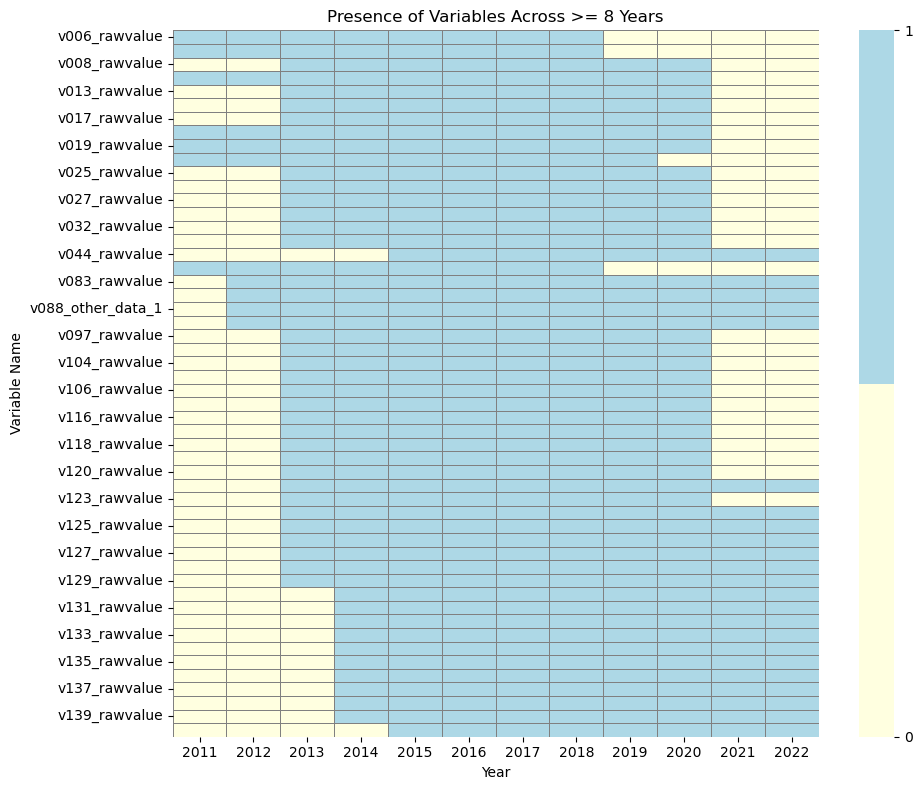

In [19]:
variable_years = filtered_inconsistent_df[["Variable Name", "Year"]]

# Create a pivot table to get the presence of variables by year (1 if present, NaN if not)
pivot_df = pd.pivot_table(
    variable_years,
    index="Variable Name",
    columns="Year",
    aggfunc=lambda x: 1,
    fill_value=0
)

colors = ["lightyellow", "lightblue"]  # 0 = yellow, 1 = blue
cmap = sns.color_palette(colors, as_cmap=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_df, cmap=cmap, cbar=True, linewidths=0.5, linecolor='grey',
    vmin=0, vmax=1, cbar_kws={"ticks": [0, 1]}  # Set color range and discrete ticks
)

plt.xlabel("Year")
plt.ylabel("Variable Name")
plt.title("Presence of Variables Across >= 8 Years")

plt.tight_layout()
plt.savefig(f"../intermediate_results/presence_of_inconsistent_variables.png", dpi=300, bbox_inches='tight')
plt.show()


###### For those with Data Spanning More Than the Threshold (8 Years), Check their Variable Names and Corresponding Measure Names
        Use 2018 as the year to match the data dictionary, since even in inconsistent data, all values (≥ 8 years) include 2018

In [20]:
for variable_name, group in filtered_inconsistent_df.groupby("Variable Name"):
    print(f"\nVariable Name: {variable_name}")
    print("Years: ", ", ".join(map(str, sorted(group["Year"].unique()))))
    print(group[["Year", "Measure", "Description"]])
    print("-" * 54)


Variable Name: v006_rawvalue
Years:  2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018
   Year                           Measure Description
0  2011  No recent dental visit raw value        None
1  2012  No recent dental visit raw value        None
2  2013  No recent dental visit raw value        None
3  2014  No recent dental visit raw value        None
4  2015  No recent dental visit raw value        None
5  2016  No recent dental visit raw value        None
6  2017  No recent dental visit raw value        None
7  2018  No recent dental visit raw value        None
------------------------------------------------------

Variable Name: v007_rawvalue
Years:  2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018
    Year                        Measure Description
8   2011  Diabetes monitoring raw value        None
9   2012  Diabetes monitoring raw value        None
10  2013  Diabetes monitoring raw value        None
11  2014  Diabetes monitoring raw value        None
12  2015  Diabetes monitoring

###### Note: Variables could be helpful in Inconsistent Data Spanning 8 or more Years

1. Variable Name: v010_rawvalue
Years:  2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Smoking during pregnancy raw value

1. Variable Name: v044_rawvalue
Years:  2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Income inequality raw value

    [Communities with greater income inequality can experience a loss of social connectedness, as well as decreases in trust, social support, and a sense of community for all residents. Income inequality within communities can have broad health impacts, including increased risk of mortality, poor health, and increased cardiovascular disease risks.](https://www.countyhealthrankings.org/health-data/health-factors/social-economic-factors/income/income-inequality?year=2024)

1. Variable Name: v047_rawvalue
Years:  2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018
Did not get needed health care raw value

1. Variable Name: v083_rawvalue
Years:  2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Limited access to healthy foods raw value 

1. Variable Name: v097_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Population growth raw value

1. Variable Name: v103_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Childhood immunizations raw value

1. Variable Name: v104_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Communicable disease raw value

1. Variable Name: v105_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Self-inflicted injury hospitalizations raw value

1. Variable Name: v116_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Reading proficiency raw value 

1. Variable Name: v118_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Poverty raw value 

1. Variable Name: v119_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Child abuse raw value

1. Variable Name: v123_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Year structure built raw value  

1. Variable Name: v125_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Air pollution - particulate matter raw value 

1. Variable Name: v128_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Child mortality raw value

1. Variable Name: v129_rawvalue
Years:  2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Infant mortality raw value 

1. Variable Name: v132_rawvalue
Years:  2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Access to exercise opportunities raw value

1. Variable Name: v133_rawvalue
Years:  2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Food environment index raw value

1. Variable Name: v136_rawvalue
Years:  2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Severe housing problems raw value

1. Variable Name: v137_rawvalue
Years:  2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Long commute - driving alone raw value

1. Variable Name: v139_rawvalue
Years:  2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Food insecurity raw value

1. Variable Name: v140_rawvalue
Years:  2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
Social associations raw value

In [21]:
filtered_inconsistent_df.sort_values(by=["Variable Name", "Year"]).to_csv(f"{data_dir}inconsistent_noLessThan8Years.csv", index=False)

# CHR csv Files

## Read files

In [22]:
CHR_csv = {}
for filename in os.listdir(data_dir):
    if re.match(r"^\d{4}CHR\.csv$", filename):
        year = filename[:4]
        filepath = os.path.join(data_dir, filename)
        CHR_csv[year] = pd.read_csv(filepath, skiprows=1)

In [23]:
CHR_csv['2011'].head()

,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,v001_cilow,v001_cihigh,v002_rawvalue,v002_numerator,v002_denominator,v002_cilow,v002_cihigh,v036_rawvalue,v036_numerator,v036_denominator,v036_cilow,v036_cihigh,v042_rawvalue,v042_numerator,v042_denominator,v042_cilow,v042_cihigh,v037_rawvalue,v037_numerator,v037_denominator,v037_cilow,v037_cihigh,v009_rawvalue,v009_numerator,v009_denominator,v009_cilow,v009_cihigh,v011_rawvalue,v011_numerator,v011_denominator,v011_cilow,v011_cihigh,v049_rawvalue,v049_numerator,v049_denominator,v049_cilow,v049_cihigh,v039_rawvalue,v039_numerator,v039_denominator,v039_cilow,v039_cihigh,v045_rawvalue,v045_numerator,v045_denominator,v045_cilow,v045_cihigh,v014_rawvalue,v014_numerator,v014_denominator,v014_cilow,v014_cihigh,v003_rawvalue,v003_numerator,v003_denominator,v003_cilow,v003_cihigh,v004_rawvalue,v004_numerator,v004_denominator,v004_cilow,v004_cihigh,v004_other_data_1,v005_rawvalue,v005_numerator,v005_denominator,v005_cilow,v005_cihigh,v007_rawvalue,v007_numerator,v007_denominator,v007_cilow,v007_cihigh,v050_rawvalue,v050_numerator,v050_denominator,v050_cilow,v050_cihigh,v021_rawvalue,v021_numerator,v021_denominator,v021_cilow,v021_cihigh,v069_rawvalue,v069_numerator,v069_denominator,v069_cilow,v069_cihigh,v023_rawvalue,v023_numerator,v023_denominator,v023_cilow,v023_cihigh,v024_rawvalue,v024_numerator,v024_denominator,v024_cilow,v024_cihigh,v040_rawvalue,v040_numerator,v040_denominator,v040_cilow,v040_cihigh,v082_rawvalue,v082_numerator,v082_denominator,v082_cilow,v082_cihigh,v043_rawvalue,v043_numerator,v043_denominator,v043_cilow,v043_cihigh,v015_rawvalue,v015_numerator,v015_denominator,v015_cilow,v015_cihigh,v046_rawvalue,v046_numerator,v046_denominator,v046_cilow,v046_cihigh,v029_rawvalue,v029_numerator,v029_denominator,v029_cilow,v029_cihigh,v030_rawvalue,v030_numerator,v030_denominator,v030_cilow,v030_cihigh,v068_rawvalue,v068_numerator,v068_denominator,v068_cilow,v068_cihigh,v060_rawvalue,v060_numerator,v060_denominator,v060_cilow,v060_cihigh,v061_rawvalue,v061_numerator,v061_denominator,v061_cilow,v061_cihigh,v070_rawvalue,v070_numerator,v070_denominator,v070_cilow,v070_cihigh,v012_rawvalue,v012_numerator,v012_denominator,v012_cilow,v012_cihigh,v062_rawvalue,v062_numerator,v062_denominator,v062_cilow,v062_cihigh,v062_other_data_1,v066_rawvalue,v066_numerator,v066_denominator,v066_cilow,v066_cihigh,v063_rawvalue,v063_numerator,v063_denominator,v063_cilow,v063_cihigh,v064_rawvalue,v064_numerator,v064_denominator,v064_cilow,v064_cihigh,v065_rawvalue,v065_numerator,v065_denominator,v065_cilow,v065_cihigh,v041_rawvalue,v041_numerator,v041_denominator,v041_cilow,v041_cihigh,v067_rawvalue,v067_numerator,v067_denominator,v067_cilow,v067_cihigh,v051_rawvalue,v051_numerator,v051_denominator,v051_cilow,v051_cihigh,v052_rawvalue,v052_numerator,v052_denominator,v052_cilow,v052_cihigh,v053_rawvalue,v053_numerator,v053_denominator,v053_cilow,v053_cihigh,v054_rawvalue,v054_numerator,v054_denominator,v054_cilow,v054_cihigh,v055_rawvalue,v055_numerator,v055_denominator,v055_cilow,v055_cihigh,v081_rawvalue,v081_numerator,v081_denominator,v081_cilow,v081_cihigh,v080_rawvalue,v080_numerator,v080_denominator,v080_cilow,v080_cihigh,v056_rawvalue,v056_numerator,v056_denominator,v056_cilow,v056_cihigh,v059_rawvalue,v059_numerator,v059_denominator,v059_cilow,v059_cihigh,v057_rawvalue,v057_numerator,v057_denominator,v057_cilow,v057_cihigh,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh,v091_rawvalue,v091_numerator,v091_denominator,v091_cilow,v091_cihigh,v010_rawvalue,v010_numerator,v010_denominator,v010_cilow,v010_cihigh,v074_rawvalue,v074_numerator,v074_denominator,v074_cilow,v074_cihigh,v095_rawvalue,v095_numerator,v095_denominator,v095_cilow,v095_cihigh,v075_rawvalue,v075_numerator,v075_denominator,v075_cilow,v075_cihigh,v076_rawvalue,v076_numerator,v076_denominator,v076_cilow,v076_cihigh,v078_rawvalue,v078_numerator,v078_den

In [24]:
var_names_from_varName_match = full_varName_match_full_year_df["Variable Name"].unique()
var_names_from_original_match = full_original_match_full_year_df["Variable Name"].unique()

combined_var_names = list(set(var_names_from_varName_match) | set(var_names_from_original_match))

In [25]:
len(combined_var_names) # number of columns we want in each file

48

## Select columns in Each CSV

Steps:
1. data dictionary generate
1. rename columns

In [26]:
dataframes = []

for year, df in CHR_csv.items():
    print(f"Year {year}: Original Shape {df.shape}")
    selected_columns = [col for col in combined_var_names if col in df.columns]
    filtered_df = df[selected_columns]
    dataframes.append(filtered_df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.head(3)

Year 2011: Original Shape (3193, 379)
Year 2012: Original Shape (3193, 330)
Year 2013: Original Shape (3193, 466)
Year 2014: Original Shape (3193, 487)
Year 2015: Original Shape (3193, 462)
Year 2016: Original Shape (3193, 482)
Year 2017: Original Shape (3195, 492)
Year 2018: Original Shape (3194, 508)
Year 2019: Original Shape (3194, 534)
Year 2020: Original Shape (3194, 786)
Year 2021: Original Shape (3194, 690)
Year 2022: Original Shape (3194, 725)


,v053_rawvalue,fipscode,v003_rawvalue,v065_rawvalue,v067_rawvalue,v059_rawvalue,v070_rawvalue,v024_rawvalue,v021_rawvalue,v055_rawvalue,v050_rawvalue,v069_rawvalue,countycode,v045_rawvalue,county_ranked,county,v060_rawvalue,v001_rawvalue,v002_rawvalue,state,v004_other_data_1,statecode,v015_rawvalue,v052_rawvalue,v043_rawvalue,v057_rawvalue,v004_rawvalue,v009_rawvalue,v061_rawvalue,v058_rawvalue,year,v042_rawvalue,v062_other_data_1,v081_rawvalue,v036_rawvalue,v037_rawvalue,v056_rawvalue,v049_rawvalue,v062_rawvalue,v082_rawvalue,v011_rawvalue,v051_rawvalue,v014_rawvalue,v080_rawvalue,v039_rawvalue,v063_rawvalue,v023_rawvalue,v005_rawvalue
0,NaN,0.0,0.196,0.432,0.759,0.086,NaN,0.182,0.739,NaN,0.634496,0.601,0,401.3,NaN,United States,NaN,7198.3,NaN,US,NaN,0,6.2,NaN,NaN,NaN,NaN,NaN,NaN,0.210,2011.0,NaN,2460.0,NaN,NaN,0.0803,NaN,NaN,0.000407,0.315,0.266,NaN,42.3,NaN,15.3,52029.0,0.093,72.4128
1,0.138,1000.0,0.171,0.512,0.835,0.020,0.305,0.221,0.671,0.005,0.625100,0.551,0,535.0,NaN,Alabama,0.119,10189.2,0.201,AL,1253.675690,1,NaN,0.239,431.9,0.516,0.000798,0.236,NaN,0.446,2011.0,4.1,5051.0,0.011,4.2,0.1021,0.031,0.126,0.000198,0.362,0.319,4708708.0,53.2,0.0,25.6,42586.0,0.101,87.9589
2,0.116,1001.0,0.155,0.288,0.855,0.008,0.327,0.149,0.740,0.005,0.695122,0.554,1,307.8,1.0,Autauga County,0.114,9967.4,0.258,AL,2288.818182,1,NaN,0.278,256.3,0.514,0.000437,0.274,169.9,0.448,2011.0,4.1,50354.0,0.006,5.2,0.0945,0.022,0.141,0.000020,0.297,0.315,50756.0,52.0,0.0,28.3,51622.0,0.089,78.8536


In [27]:
combined_df.shape

(38323, 48)

## Columns Rename & Customize Data Dictionary

### Sort Column Names in combined_df

In [28]:
combined_df = combined_df[sorted(combined_df.columns)]

### Match Columns to the Data Dictionary

        2022 was selected becaseu it contains descriptions, and is the most updated version in OUR STUDY RANGE from 2011 to 2022

In [29]:
dd2022 = pd.DataFrame(all_measures['2022']).rename(columns={0: "variable_name", 1: "Measure", 2: "Description"})
dd2022

,variable_name,Measure,Description
0,statecode,State FIPS Code,
1,countycode,County FIPS Code,
2,fipscode,5-digit FIPS Code,
3,state,State Abbreviation,
4,county,Name,
...,...,...,...
209,v056_rawvalue,% Hispanic raw value,Percentage of population self-identifying as H...
210,v126_rawvalue,% non-Hispanic white raw value,Percentage of population self-identifying as n...
211,v059_rawvalue,% not proficient in English raw value,Percentage of population that is not proficien...
212,v057_rawvalue,% female raw value,Percentage of population that is female.


In [30]:
missing_columns = []
dd2022_filtered = dd2022[dd2022['variable_name'].isin(combined_df.columns)].copy()
dd2022_filtered['matched_col_names'] = None

for col in combined_df.columns:
    match = dd2022_filtered[dd2022_filtered['variable_name'] == col]

    if not match.empty:
        measure_name = match.iloc[0]['Measure'].replace('\n', ' ')
        if 'raw value' in measure_name.lower():
            new_name = measure_name.replace('raw value', '').strip().replace(' ', '_').lower()
        elif col.startswith('v'):
            new_name = measure_name.strip().replace(' ', '_').lower()
        else:
            new_name = col.strip().lower()

        dd2022_filtered.loc[match.index[0], 'matched_col_names'] = new_name
    else:
        missing_columns.append(col)

if len(missing_columns) > 0:
    print(f"Go back and check matching: {missing_columns}")

In [31]:
dd2022_filtered

,variable_name,Measure,Description,matched_col_names
0,statecode,State FIPS Code,,statecode
1,countycode,County FIPS Code,,countycode
2,fipscode,5-digit FIPS Code,,fipscode
3,state,State Abbreviation,,state
4,county,Name,,county
5,year,Release Year,,year
6,county_ranked,County Ranked (Yes=1/No=0),,county_ranked
7,v001_rawvalue,Premature death raw value,Years of potential life lost before age 75 per...,premature_death
19,v002_rawvalue,Poor or fair health raw value,Percentage of adults reporting fair or poor he...,poor_or_fair_health
20,v036_rawvalue,Poor physical health days raw value,Average number of physically unhealthy days re...,poor_physical_health_days


In [34]:
for i in range(0, len(dd2022_filtered), 3):
    print(dd2022_filtered['Measure'].iloc[i:i+3], sep=',')


0      State FIPS Code
1     County FIPS Code
2    5-digit FIPS Code
Name: Measure, dtype: object
3    State Abbreviation
4                  Name
5          Release Year
Name: Measure, dtype: object
6        County Ranked (Yes=1/No=0)
7         Premature death raw value
19    Poor or fair health raw value
Name: Measure, dtype: object
20    Poor physical health days raw value
21      Poor mental health days raw value
22              Low birthweight raw value
Name: Measure, dtype: object
29          Adult smoking raw value
30          Adult obesity raw value
32    Physical inactivity raw value
Name: Measure, dtype: object
34                  Excessive drinking raw value
36    Sexually transmitted infections raw\nvalue
37                         Teen births raw value
Name: Measure, dtype: object
44                   Primary care physicians raw value
45    Ratio of population to primary care\nphysicians.
48                   Mental health providers raw value
Name: Measure, dtype: object
49

In [30]:
dd2022_filtered.shape

(48, 4)

### Save the Customized Data Dictionary

In [31]:
dd2022_filtered.to_csv(f"{data_dir}dd2022_consistency.csv", index=False)

### Rename the Columns in combined_df Using the Generated Dictionary

In [32]:
rename_dict = dd2022_filtered.set_index('variable_name')['matched_col_names'].to_dict()
combined_df = combined_df.rename(columns=rename_dict)

In [33]:
combined_df.head(4)

,county,county_ranked,countycode,fipscode,state,statecode,premature_death,poor_or_fair_health,uninsured_adults,ratio_of_population_to_primary_care_physicians.,primary_care_physicians,preventable_hospital_stays,adult_smoking,adult_obesity,teen_births,homicides,high_school_graduation,unemployment,children_in_poverty,poor_physical_health_days,low_birthweight,motor_vehicle_crash_deaths,poor_mental_health_days,violent_crime,sexually_transmitted_infections,excessive_drinking,mammography_screening,population,%_below_18_years_of_age,%_65_and_older,%_american_indian_&_alaska_native,%_hispanic,%_female,%_rural,%_not_proficient_in_english,diabetes_prevalence,hiv_prevalence,ratio_of_population_to_mental_health_providers.,mental_health_providers,median_household_income,children_eligible_for_free_or_reduced_price_lunch,driving_alone_to_work,some_college,physical_inactivity,%_native_hawaiian/other_pacific_islander,%_asian,children_in_single-parent_households,year
0,United States,NaN,0,0.0,US,0,7198.3,NaN,0.196,NaN,NaN,72.4128,NaN,0.266,42.3,6.2,0.739,0.093,0.182,NaN,0.0803,15.3,NaN,NaN,401.3,NaN,0.634496,NaN,NaN,NaN,NaN,NaN,NaN,0.210,0.086,NaN,NaN,2460.0,0.000407,52029.0,0.432,0.759,0.601,NaN,NaN,NaN,0.315,2011.0
1,Alabama,NaN,0,1000.0,AL,1,10189.2,0.201,0.171,1253.675690,0.000798,87.9589,0.236,0.319,53.2,NaN,0.671,0.101,0.221,4.2,0.1021,25.6,4.1,431.9,535.0,0.126,0.625100,4708708.0,0.239,0.138,0.005,0.031,0.516,0.446,0.020,0.119,NaN,5051.0,0.000198,42586.0,0.512,0.835,0.551,0.305,0.0,0.011,0.362,2011.0
2,Autauga County,1.0,1,1001.0,AL,1,9967.4,0.258,0.155,2288.818182,0.000437,78.8536,0.274,0.315,52.0,NaN,0.740,0.089,0.149,5.2,0.0945,28.3,4.1,256.3,307.8,0.141,0.695122,50756.0,0.278,0.116,0.005,0.022,0.514,0.448,0.008,0.114,169.9,50354.0,0.000020,51622.0,0.288,0.855,0.554,0.327,0.0,0.006,0.297,2011.0
3,Baldwin County,1.0,3,1003.0,AL,1,8321.8,0.128,0.209,1223.694444,0.000817,63.9873,0.219,0.262,49.6,NaN,0.681,0.088,0.151,3.4,0.0882,23.2,4.1,194.7,226.4,0.194,0.724967,179878.0,0.231,0.170,0.005,0.033,0.510,0.542,0.018,0.098,176.1,6076.0,0.000165,51957.0,0.289,0.829,0.615,0.252,0.0,0.006,0.289,2011.0


## Calculation

Steps:
1. select columns to calculate
2. calculate & naming & save in new columns
3. generate according data dictionary

In [34]:
combined_df.columns

Index(['county', 'county_ranked', 'countycode', 'fipscode', 'state',
       'statecode', 'premature_death', 'poor_or_fair_health',
       'uninsured_adults', 'ratio_of_population_to_primary_care_physicians.',
       'primary_care_physicians', 'preventable_hospital_stays',
       'adult_smoking', 'adult_obesity', 'teen_births', 'homicides',
       'high_school_graduation', 'unemployment', 'children_in_poverty',
       'poor_physical_health_days', 'low_birthweight',
       'motor_vehicle_crash_deaths', 'poor_mental_health_days',
       'violent_crime', 'sexually_transmitted_infections',
       'excessive_drinking', 'mammography_screening', 'population',
       '%_below_18_years_of_age', '%_65_and_older',
       '%_american_indian_&_alaska_native', '%_hispanic', '%_female',
       '%_rural', '%_not_proficient_in_english', 'diabetes_prevalence',
       'hiv_prevalence', 'ratio_of_population_to_mental_health_providers.',
       'mental_health_providers', 'median_household_income',
       'c

In [35]:
combined_df.head(2)

,county,county_ranked,countycode,fipscode,state,statecode,premature_death,poor_or_fair_health,uninsured_adults,ratio_of_population_to_primary_care_physicians.,primary_care_physicians,preventable_hospital_stays,adult_smoking,adult_obesity,teen_births,homicides,high_school_graduation,unemployment,children_in_poverty,poor_physical_health_days,low_birthweight,motor_vehicle_crash_deaths,poor_mental_health_days,violent_crime,sexually_transmitted_infections,excessive_drinking,mammography_screening,population,%_below_18_years_of_age,%_65_and_older,%_american_indian_&_alaska_native,%_hispanic,%_female,%_rural,%_not_proficient_in_english,diabetes_prevalence,hiv_prevalence,ratio_of_population_to_mental_health_providers.,mental_health_providers,median_household_income,children_eligible_for_free_or_reduced_price_lunch,driving_alone_to_work,some_college,physical_inactivity,%_native_hawaiian/other_pacific_islander,%_asian,children_in_single-parent_households,year
0,United States,NaN,0,0.0,US,0,7198.3,NaN,0.196,NaN,NaN,72.4128,NaN,0.266,42.3,6.2,0.739,0.093,0.182,NaN,0.0803,15.3,NaN,NaN,401.3,NaN,0.634496,NaN,NaN,NaN,NaN,NaN,NaN,0.210,0.086,NaN,NaN,2460.0,0.000407,52029.0,0.432,0.759,0.601,NaN,NaN,NaN,0.315,2011.0
1,Alabama,NaN,0,1000.0,AL,1,10189.2,0.201,0.171,1253.67569,0.000798,87.9589,0.236,0.319,53.2,NaN,0.671,0.101,0.221,4.2,0.1021,25.6,4.1,431.9,535.0,0.126,0.625100,4708708.0,0.239,0.138,0.005,0.031,0.516,0.446,0.020,0.119,NaN,5051.0,0.000198,42586.0,0.512,0.835,0.551,0.305,0.0,0.011,0.362,2011.0


In [36]:
combined_df.poor_or_fair_health.max()

0.508

### Define Metrics

Though the name contains %, they are all less than 1. Based on empiral experience and manual check, we regard it as ratio

In [37]:

combined_df['adult_population'] = combined_df['population'] * (1 - combined_df['%_below_18_years_of_age']) # above 18+ (age)
combined_df['adult_population18_65'] = combined_df['population'] * (1 - combined_df['%_below_18_years_of_age'] - combined_df['%_65_and_older']) # adults: 18-65 (age)
combined_df['population_below_18']  = combined_df['population'] * combined_df['%_below_18_years_of_age'] # adults: 18-65 (age)

metrics = {
    'Premature death': {
        'column': 'premature_death',
        'formula': lambda combined_df: (combined_df['premature_death'] / 100_000) * combined_df['population']
    },
    'Poor or fair health': {
        'column': 'poor_or_fair_health',
        'population_type': 'adult_population'
    },
    'Poor physical health days': {
        'column': 'poor_physical_health_days',
        'formula': lambda combined_df: (combined_df['poor_physical_health_days'] / 30) * combined_df['population']
    },
    'Poor mental health days': {
        'column': 'poor_mental_health_days',
        'formula': lambda combined_df: (combined_df['poor_mental_health_days'] / 30) * combined_df['population']
    },
    'Adult smoking': {
        'column': 'adult_smoking',
        'population_type': 'adult_population'
    },
    'Adult obesity': {
        'column': 'adult_obesity',
        'population_type': 'adult_population'
    },
    'Physical inactivity': {
        'column': 'physical_inactivity',
        'population_type': 'adult_population'
    },
    'Excessive drinking': { # adults? 21? 18?
        'column': 'excessive_drinking',
        'population_type': 'adult_population'
    },
    'Sexually transmitted infections': {
        'column': 'sexually_transmitted_infections',
        'formula': lambda combined_df: (combined_df['sexually_transmitted_infections'] / 100_000) * combined_df['population']
    },
    'Primary care physicians': {
        'column': 'primary_care_physicians',
        'formula': lambda combined_df: (combined_df['population'] / 100_000 ) / combined_df['primary_care_physicians']
    },
    'Mental health providers': {
        'column': 'mental_health_providers',
        'formula': lambda combined_df: (combined_df['population'] / 100_000) / combined_df['mental_health_providers']
    },
    'Children in Poverty': {
        'column': 'children_in_poverty',
        'formula': lambda combined_df: combined_df['children_in_poverty'] * combined_df['population_below_18']
    },
    'Children in Single-Parent Households': {
        'column': 'children_in_single-parent_households',
        'formula': lambda combined_df: combined_df['children_in_single-parent_households'] * combined_df['population_below_18']
    },
    'Violent crime': {
        'column': 'violent_crime',
        'formula': lambda combined_df: (combined_df['violent_crime'] / 100_000) * combined_df['population']
    },
    'Motor vehicle crash deaths': {
        'column': 'motor_vehicle_crash_deaths',
        'formula': lambda combined_df: (combined_df['motor_vehicle_crash_deaths'] / 100_000) * combined_df['population']
    },
    'Uninsured adults': {
        'column': 'uninsured_adults',
        'population_type': 'adult_population18_65' # 18-65
    },
    'Homicides': {
        'column': 'homicides',
        'formula': lambda combined_df: (combined_df['homicides'] / 100_000) * combined_df['population']
    },
    '% below 18 years of age': {
        'column': '%_below_18_years_of_age',
        'population_type': 'population'
    },
    '% 65 and older': {
        'column': '%_65_and_older',
        'population_type': 'population'
    },
    'Not proficient in English': {
        'column': '%_not_proficient_in_english',

        'population_type': 'population'
    },
    '% female': {
        'column': '%_female',
        'population_type': 'population'
    },
    '% rural': {
        'column': '%_rural',
        'population_type': 'population'
    }
}

In [38]:
for measure, details in metrics.items():
    col_name = details['column']
    cleaned_col_name = col_name.replace('%_', '')
    new_col_name = f"total_{cleaned_col_name}"

    if 'formula' in details:
        combined_df[new_col_name] = details['formula'](combined_df)
    else:
        population_type = details['population_type']
        combined_df[new_col_name] = combined_df[col_name] * combined_df[population_type]
    print(measure)
    print(new_col_name)

    # dd2022_filtered.append({
    #     'Measure': measure,
    #     'Description': f"Total {measure.lower()} based on the given population.",
    #     'Column Name': new_col_name
    # })

Premature death
total_premature_death
Poor or fair health
total_poor_or_fair_health
Poor physical health days
total_poor_physical_health_days
Poor mental health days
total_poor_mental_health_days
Adult smoking
total_adult_smoking
Adult obesity
total_adult_obesity
Physical inactivity
total_physical_inactivity
Excessive drinking
total_excessive_drinking
Sexually transmitted infections
total_sexually_transmitted_infections
Primary care physicians
total_primary_care_physicians
Mental health providers
total_mental_health_providers
Children in Poverty
total_children_in_poverty
Children in Single-Parent Households
total_children_in_single-parent_households
Violent crime
total_violent_crime
Motor vehicle crash deaths
total_motor_vehicle_crash_deaths
Uninsured adults
total_uninsured_adults
Homicides
total_homicides
% below 18 years of age
total_below_18_years_of_age
% 65 and older
total_65_and_older
Not proficient in English
total_not_proficient_in_english
% female
total_female
% rural
total_ru

In [39]:
combined_df.shape

(38323, 73)

In [40]:
combined_df.head(3)

,county,county_ranked,countycode,fipscode,state,statecode,premature_death,poor_or_fair_health,uninsured_adults,ratio_of_population_to_primary_care_physicians.,primary_care_physicians,preventable_hospital_stays,adult_smoking,adult_obesity,teen_births,homicides,high_school_graduation,unemployment,children_in_poverty,poor_physical_health_days,low_birthweight,motor_vehicle_crash_deaths,poor_mental_health_days,violent_crime,sexually_transmitted_infections,excessive_drinking,mammography_screening,population,%_below_18_years_of_age,%_65_and_older,%_american_indian_&_alaska_native,%_hispanic,%_female,%_rural,%_not_proficient_in_english,diabetes_prevalence,hiv_prevalence,ratio_of_population_to_mental_health_providers.,mental_health_providers,median_household_income,children_eligible_for_free_or_reduced_price_lunch,driving_alone_to_work,some_college,physical_inactivity,%_native_hawaiian/other_pacific_islander,%_asian,children_in_single-parent_households,year,adult_population,adult_population18_65,population_below_18,total_premature_death,total_poor_or_fair_health,total_poor_physical_health_days,total_poor_mental_health_days,total_adult_smoking,total_adult_obesity,total_physical_inactivity,total_excessive_drinking,total_sexually_transmitted_infections,total_primary_care_physicians,total_mental_health_providers,total_children_in_poverty,total_children_in_single-parent_households,total_violent_crime,total_motor_vehicle_crash_deaths,total_uninsured_adults,total_homicides,total_below_18_years_of_age,total_65_and_older,total_not_proficient_in_english,total_female,total_rural
0,United States,NaN,0,0.0,US,0,7198.3,NaN,0.196,NaN,NaN,72.4128,NaN,0.266,42.3,6.2,0.739,0.093,0.182,NaN,0.0803,15.3,NaN,NaN,401.3,NaN,0.634496,NaN,NaN,NaN,NaN,NaN,NaN,0.210,0.086,NaN,NaN,2460.0,0.000407,52029.0,0.432,0.759,0.601,NaN,NaN,NaN,0.315,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,NaN,0,1000.0,AL,1,10189.2,0.201,0.171,1253.675690,0.000798,87.9589,0.236,0.319,53.2,NaN,0.671,0.101,0.221,4.2,0.1021,25.6,4.1,431.9,535.0,0.126,0.625100,4708708.0,0.239,0.138,0.005,0.031,0.516,0.446,0.020,0.119,NaN,5051.0,0.000198,42586.0,0.512,0.835,0.551,0.305,0.0,0.011,0.362,2011.0,3583326.788,2933525.084,1125381.212,479779.675536,720248.684388,659219.120000,643523.426667,845665.121968,1.143081e+06,1.092915e+06,451499.175288,25191.587800,59031.924223,237813.535354,248709.247852,407387.998744,20336.909852,1205.429248,501632.789364,NaN,1125381.212,649801.704,94174.160,2429693.328,2100083.768
2,Autauga County,1.0,1,1001.0,AL,1,9967.4,0.258,0.155,2288.818182,0.000437,78.8536,0.274,0.315,52.0,NaN,0.740,0.089,0.149,5.2,0.0945,28.3,4.1,256.3,307.8,0.141,0.695122,50756.0,0.278,0.116,0.005,0.022,0.514,0.448,0.008,0.114,169.9,50354.0,0.000020,51622.0,0.288,0.855,0.554,0.327,0.0,0.006,0.297,2011.0,36645.832,30758.136,14110.168,5059.053544,9454.624656,8797.706667,6936.653333,10040.957968,1.154344e+04,1.198319e+04,5167.062312,156.226968,1161.712558,25378.000000,2102.415032,4190.719896,130.087628,14.363948,4767.511080,NaN,14110.168,5887.696,406.048,26088.584,22738.688


In [41]:
combined_df[combined_df.fipscode == 48085]

,county,county_ranked,countycode,fipscode,state,statecode,premature_death,poor_or_fair_health,uninsured_adults,ratio_of_population_to_primary_care_physicians.,primary_care_physicians,preventable_hospital_stays,adult_smoking,adult_obesity,teen_births,homicides,high_school_graduation,unemployment,children_in_poverty,poor_physical_health_days,low_birthweight,motor_vehicle_crash_deaths,poor_mental_health_days,violent_crime,sexually_transmitted_infections,excessive_drinking,mammography_screening,population,%_below_18_years_of_age,%_65_and_older,%_american_indian_&_alaska_native,%_hispanic,%_female,%_rural,%_not_proficient_in_english,diabetes_prevalence,hiv_prevalence,ratio_of_population_to_mental_health_providers.,mental_health_providers,median_household_income,children_eligible_for_free_or_reduced_price_lunch,driving_alone_to_work,some_college,physical_inactivity,%_native_hawaiian/other_pacific_islander,%_asian,children_in_single-parent_households,year,adult_population,adult_population18_65,population_below_18,total_premature_death,total_poor_or_fair_health,total_poor_physical_health_days,total_poor_mental_health_days,total_adult_smoking,total_adult_obesity,total_physical_inactivity,total_excessive_drinking,total_sexually_transmitted_infections,total_primary_care_physicians,total_mental_health_providers,total_children_in_poverty,total_children_in_single-parent_households,total_violent_crime,total_motor_vehicle_crash_deaths,total_uninsured_adults,total_homicides,total_below_18_years_of_age,total_65_and_older,total_not_proficient_in_english,total_female,total_rural
2608,Collin County,1.0,85,48085.0,TX,48,4070.200000,0.113000,0.196000,1095.319943,0.000913,73.893000,0.127000,0.234,25.500000,NaN,0.897000,0.073000,0.080,2.700000,0.075700,8.900000,2.700000,255.400000,203.10000,0.137000,0.656972,791631.0,0.280000,0.080000,0.007000,0.145000,0.498000,0.102000,0.093000,0.074,127.800000,3129.000000,0.000320,81875.0,0.155000,0.814000,0.785000,0.202,0.001000,0.102000,0.183000,2011.0,569974.320000,506643.840000,221656.680000,32220.964962,64407.098160,71246.790000,71246.790000,72386.738640,133373.990880,115134.812640,78086.481840,1607.802561,8670.891754,24738.468750,17732.534400,40563.172440,2021.825574,70.455159,99302.192640,NaN,221656.680000,63330.480000,73621.683000,394232.238000,80746.362000
5801,Collin County,1.0,85,48085.0,TX,48,4037.620000,0.108000,0.189000,1095.319943,0.000913,65.737698,0.112000,0.246,23.900000,2.175000,0.936000,0.075000,0.096,2.700000,0.076000,8.615322,2.500000,223.003949,225.50000,0.132000,0.693766,791631.0,0.280000,0.080000,0.007000,0.145000,0.498000,0.102000,0.090969,0.071,133.350000,3129.000000,0.000320,77862.0,0.155000,0.815243,0.794748,0.217,0.001000,0.102000,0.184702,2012.0,569974.320000,506643.840000,221656.680000,31963.051582,61557.226560,71246.790000,65969.250000,63837.123840,140213.682720,123684.427440,75236.610240,1785.127905,8670.891754,24738.468750,21279.041280,40940.378247,1765.368394,68.201558,95755.685760,17.217974,221656.680000,63330.480000,72014.037103,394232.238000,80746.362000
8994,Collin County,1.0,85,48085.0,TX,48,4133.800000,0.107000,0.199000,1235.910658,0.000809,62.670000,0.115000,0.246,23.113217,1.837400,0.949000,0.070000,0.099,2.800000,0.077000,7.571704,2.600000,202.805029,251.40000,0.134000,0.690170,812226.0,0.283099,0.080906,0.007531,0.152248,0.507953,0.052427,0.042419,0.071,140.900000,3369.705128,0.000297,82765.0,0.197359,0.814960,0.794431,0.217,0.000824,0.115218,0.194049,2013.0,582285.999970,516572.000004,229940.000030,33575.798388,62304.601997,75807.760000,70392.920000,66962.889997,143242.355993,126356.061994,78026.323996,2041.936164,10038.387384,27369.618539,22764.060003,44619.716765,1647.235179,61.499349,102797.828001,14.923842,229940.000030,65713.999966,34453.734852,412573.000017,42582.788879
12187,Collin County,1.0,85,48085.0,TX,48,4133.800000,0.097000,0.190360,1099.087957,0.000910,56.770258,0.097000,0.245,21.631079,1.837400,0.947033,0.060730,0.098,2.800000,0.077000,7.571704,2.400000,1

In [37]:
len(combined_df.county.unique())

1975

In [40]:
grouped_data = combined_df.groupby('year')['county'].nunique()

# Convert the index (years) to integers and print
grouped_data.index = grouped_data.index.astype(int)
print(grouped_data)


year
2011    1927
2012    1927
2013    1927
2014    1926
2015    1926
2016    1926
2017    1921
2018    1928
2019    1928
2020    1928
2021    1928
2022    1928
Name: county, dtype: int64


# Save the Final csv

In [42]:
combined_df[sorted(combined_df.columns)].to_csv(f"{data_dir}combinedCHR_selectedColumns_calculated.csv", index=False)